In [57]:
import os
import torch
import yaml
from typing import Tuple, Any
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

import configparser
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

In [58]:
torch.cuda.is_available()
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [59]:
# setting device on GPU if available, else CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [60]:
def load_config(config_file='config.yaml'):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config()

In [61]:
class MushroomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset initialisation.
        :param root_dir: Path to the directory with the images.
        :param transform: Transforms applied to the data.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for mushroom_name in os.listdir(root_dir):
            mushroom_folder = os.path.join(root_dir, mushroom_name)
            if os.path.isdir(mushroom_folder):
                for image_name in os.listdir(mushroom_folder):
                    if image_name.endswith(('.png', '.jpg', '.jpeg')):  
                        self.image_paths.append(os.path.join(mushroom_folder, image_name))
                        self.labels.append(mushroom_name)

        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [62]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])




In [63]:
# Создаем объект датасета
dataset = MushroomDataset(root_dir=config['mushrooms']['dataset'], transform=transform)

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [64]:
from tqdm import tqdm

In [65]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 1, 2, 3).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [66]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [67]:
EPOCHS = 100
LR = 0.001

# hist = train(net, train_dataloader, device, EPOCHS, LR)

In [68]:
import torch

def build_MOCNN_S():
    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)
        elif isinstance(m, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)
    
    # Строим модель
    mocnn = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=5, padding=2),  # Вход: 3 канала (RGB)
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=6, stride=6),
        
        torch.nn.Conv2d(32, 40, kernel_size=5, padding=2),  # Вход: 3 канала (RGB)
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=4, stride=4),# После AvgPool размер будет 32x16x16
        
        torch.nn.Flatten(),
        
        # Размерность после свертки и пулинга будет 32 * 16 * 16 = 8192
        torch.nn.Linear(3240, 120),
        torch.nn.Sigmoid(),
        
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        
        torch.nn.Linear(84, 10)  # Количество выходных нейронов зависит от количества классов
    )
  
    # Применяем инициализацию
    mocnn.apply(init_weights)
    
    return mocnn


In [69]:
mocnn = build_MOCNN_S()
mocnn.to(device)
print(device)

cuda


In [70]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    output = build_MOCNN_S()
print(prof.key_averages().table(sort_by="cuda_time_total"))

------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
      aten::detach         0.84%      49.700us         1.39%      81.800us       8.180us      41.000us        33.06%      61.000us       6.100us            10  
    aten::uniform_        97.26%       5.741ms        97.26%       5.741ms     382.707us      30.000us        24.19%      30.000us       2.000us            15  
       aten::empty         0.77%      45.400us         0.77%      45.400us       4.540us      22.000us        17.74%      22.000us       2.200us            10  
            detach         0.54% 

C:\Users\ПК\AppData\Local\Temp\ipykernel_98512\1339680574.py:1: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


Epoch: 99, Batch: 83, Loss: 183267.33, Acc: 0.20: 100%|██████████| 8400/8400 [1:09:48<00:00,  2.01it/s]


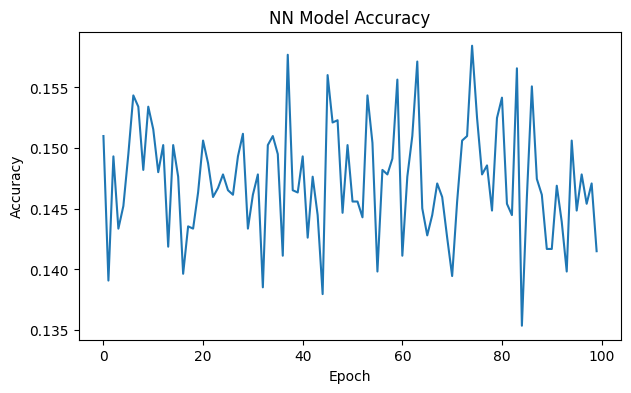

In [71]:
mocnn_hist = train(mocnn, train_loader, device, EPOCHS, 64)
print_history(mocnn_hist, "NN Model Accuracy")